## import and custom settings

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai import *
from fastai.vision import *
PATH = "./data/"
sz=128
data = ImageDataBunch.from_folder('data', ds_tfms=get_transforms(), size=sz)

## using vgg16 as network

In [2]:
#learn = cnn_learner(data,models.alexnet,metrics=[accuracy])#[error_rate, kappa]
learn = cnn_learner(data,models.vgg16_bn,metrics=[error_rate, accuracy], callback_fns=ShowGraph)#error_rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


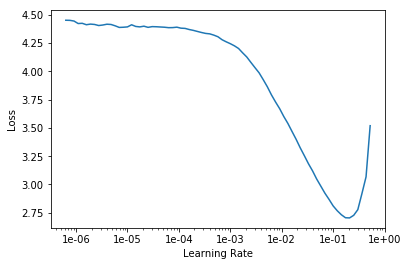

In [3]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.050292,11.008244,0.411638,0.588362,00:23
1,2.474831,0.139544,0.015086,0.984914,00:22
2,0.770625,1.411869,0.008621,0.991379,00:22
3,0.269192,0.005759,0.004310,0.995690,00:22


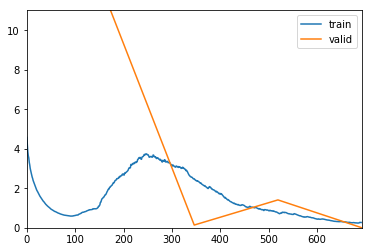

In [4]:
lr = 1e-01
learn.fit_one_cycle(4,slice(lr))
learn.save('stage1',return_path=True)
learn.unfreeze()

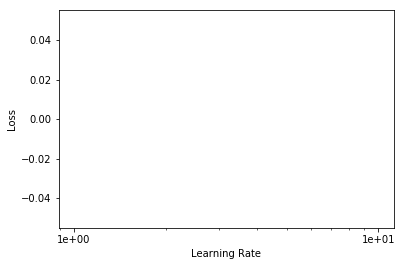

In [6]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.643889,3.753499,0.178879,0.821121,00:32
1,3.302161,530.323120,0.422414,0.577586,00:32
2,1.729530,0.094843,0.008621,0.991379,00:32
3,0.822012,0.186552,0.028017,0.971983,00:32
4,0.236425,0.024730,0.004310,0.995690,00:32


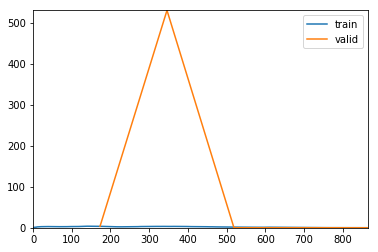

PosixPath('data/models/stage2.pth')

In [7]:
learn.fit_one_cycle(5,slice(lr))
learn.save('stage2',return_path=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.203698,0.022143,0.004310,0.995690,00:32
1,0.175082,0.003855,0.004310,0.995690,00:32
2,0.162226,0.004430,0.004310,0.995690,00:32
3,0.117706,0.024986,0.004310,0.995690,00:32
4,0.133420,0.043471,0.004310,0.995690,00:32
5,0.158828,0.011857,0.004310,0.995690,00:32
6,0.112396,0.002161,0.000000,1.000000,00:32
7,0.101527,0.001338,0.000000,1.000000,00:32
8,0.086474,0.041749,0.004310,0.995690,00:32
9,0.125119,0.005801,0.004310,0.995690,00:32


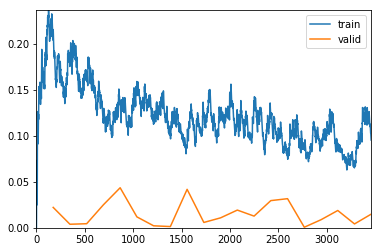

In [9]:
learning_rate=1e-4
learn.fit(20,learning_rate)

## 训练完成后可视化

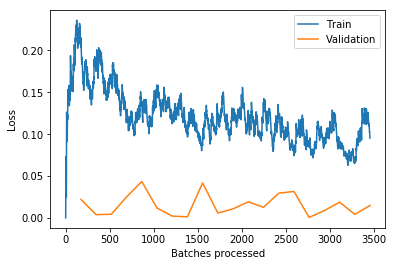

In [10]:
learn.recorder.plot_losses()

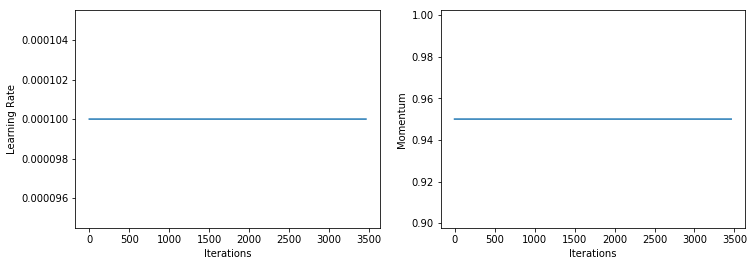

In [11]:
learn.recorder.plot_lr(show_moms=True)

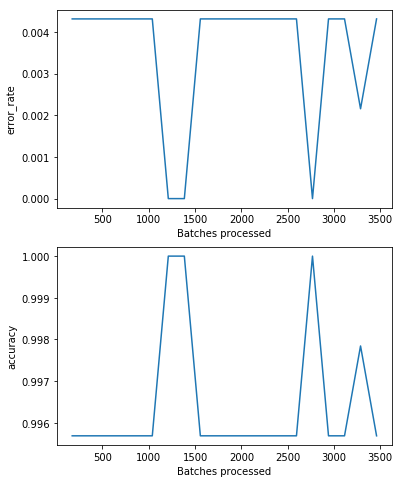

In [12]:
learn.recorder.plot_metrics()

### 查看那些分类错了

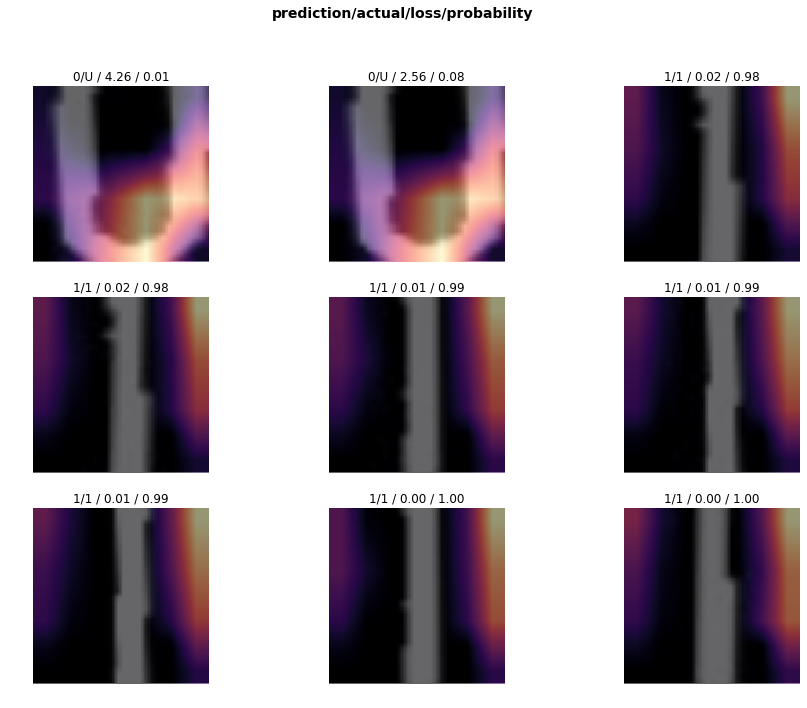

In [13]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(15,11))

### 查看混淆矩阵

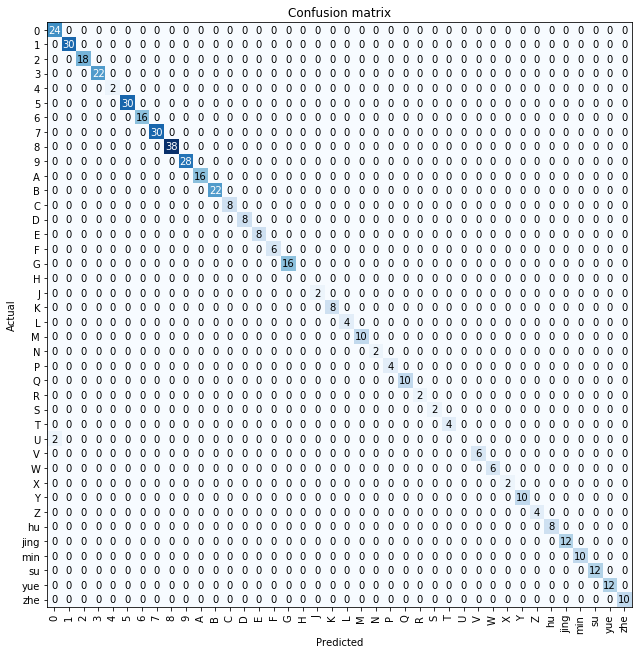

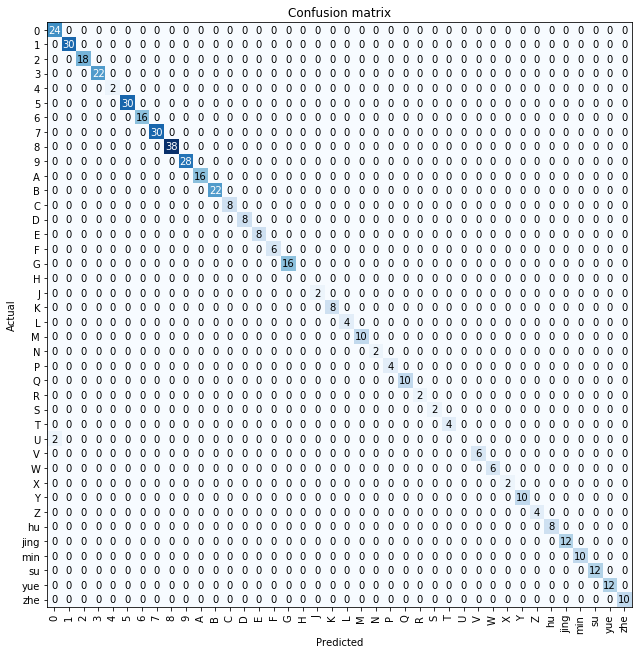

In [14]:
interp.plot_confusion_matrix(figsize=(9,9))
#show_doc(ClassificationInterpretation.confusion_matrix)
interp.plot_confusion_matrix(slice_size=3,figsize=(9,9))

### 进行分类

In [16]:
paths_img = PATH+'/'+'test'
images = get_images_files(paths_img)
print(image[:5])

# 打开一个图片
img = open_image(images[0])
label,idx,prob = learn.predict(img)
print('预测的分类为{}, 概率为{:.4f}'.format(label, prob[idx]))

NameError: name 'get_images_files' is not defined

### 创建网络模型

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
)


CUDA_LAUNCH_BLOCKING=1
learner = Learner(data, model)
#learner.fit(5)
learner.fit_one_cycle(10, 1e-1)

In [ ]:
data = learn
data

## visualize

In [ ]:
img = learn.data.train_ds[0][0]

_,axs = plt.subplots(1,4,figsize=(12,4))
for i,ax in enumerate(axs):
    learn.data.train_ds[0][0].show(ax=ax, title=f'number')

In [ ]:
# classes
learn.data.classes

In [ ]:
data.show_batch()

In [ ]:
learn.validate()
learn.validate(learn.data.valid_dl)
learn.validate(learn.data.train_dl)

In [ ]:
learn.show_results()

In [ ]:
learn.show_results(ds_type=DatasetType.Train)

In [ ]:
learn.show_results(ds_type=DatasetType.Valid)

In [ ]:
log_preds = learn.predict()
print("shape:", log_preds.shape)

preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])


def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0],
                            min(len(preds), 4), 
                            replace=False)


def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y) 
                               == is_correct)


def plots(ims, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))


def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found.')

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]


def most_by_correct(y, is_correct):
    mult = -1 if (y == 1) == is_correct else 1
    return most_by_mask(((preds == data.val_y) == is_correct) & (data.val_y == y), mult)

plot_val_with_title(rand_by_correct(True), "Correctly classified")
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")


In [ ]:
tfms = get_transforms(models.resnet34, sz, max_zoom=1.1)

def get_augs():
    data = ImageDataBunch.from_folder(PATH, bs=2, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

## 查看文档

In [21]:
doc(get_transforms())

NameError: name 'doc' is not defined

In [20]:
### 查看summary

from fastai.callbacks import model_summary
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       1,792      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [64, 128, 128]       36,928     True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________